In [1]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt
import time

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from category_encoders import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("Data/Train.csv")
df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [138]:
df["ad_type"].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD',
       'RESPONSIVE_SEARCH_AD', nan], dtype=object)

### Previous code (keep)

In [185]:
def wrangle(df, identifiant):
    
    # Substract the datafram according to the ID
    data = df[df["ID"].str.contains(identifiant)].copy()

    # Convert the cost in ZAR
    data.loc[data["currency"] == "USD", "cost_zar"] = data["cost"] * 19.18
    data.loc[data["currency"] != "USD", "cost_zar"] = data["cost"]

    drop_cols = ["ID", "currency", "cost", "conversions", "conversions_calls", "headline1_len", "impression_share", "headline2_len", "ad_description_len"] # We don't need the ID anymore since it is only one  

    # List null values columns to drop
    null_proportions = pd.DataFrame({"Null proportions":data.isnull().sum()/len(data)})
    drop_cols.extend(data.columns[null_proportions["Null proportions"]>0.7])

    data = data.drop(columns=drop_cols)

    campains = data[["impressions","clicks", "ad_type","date", "cost_zar"]]
    ad_data = data.drop(columns = ["impressions","clicks", "ad_type", "cost_zar"])
    campains = campains.groupby("date").sum().sort_values(by="date")
    ad_data = round(ad_data.groupby("date").mean(),0).sort_values(by="date")
    data = pd.concat([campains, ad_data], axis = 1)
    
    data.loc[data["ad_type"].str.contains("EXPANDED_TEXT_AD"), "EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
    data.loc[data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD"), "EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
    data.loc[data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD"), "RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
    data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)

    data.drop(columns="ad_type", inplace=True)
    return data.astype(int)

### New code (modified)

In [42]:
def wrangle(df, identifiant):
    
    # Substract the datafram according to the ID
    data = df[df["ID"].str.contains(identifiant)].copy()

    # Convert the cost in ZAR
    data.loc[data["currency"] == "USD", "cost_zar"] = data["cost"] * 19.18
    data.loc[data["currency"] != "USD", "cost_zar"] = data["cost"]

    drop_cols = ["ID", "currency", "cost", "conversions", "conversions_calls", "headline1_len", "impression_share", "headline2_len", "ad_description_len", "call_type", "call_status", "start_time", "duration", "end_time", "display_location"] # We don't need the ID anymore since it is only one  
    data = data.drop(columns=drop_cols)

    data = data.groupby("date").sum()
    data.index = pd.to_datetime(data.index)

    #campains = data[["impressions","clicks", "ad_type", "cost_zar"]]
    data = data.resample("D").sum().bfill()

    # Create new variables that will be True or False if the client lunched a campain of this ad_type
    data["EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
    data["EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
    data["RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
    data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)
    
    data.drop(columns="ad_type", inplace=True)
    
    def difference(data, target):
    
        diff = data.drop(target, axis = 1).diff().fillna(0)
        dicto = {}
        
        for col in list(diff.columns):
            dicto[col] = f"{col}_diff"
        
        diff = diff.rename(columns=dicto)
        
        return pd.concat([data, diff], axis = 1)
    
    data = difference(data, ["clicks", "EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"])
    
    return data

In [43]:
client = "ID_5da86e71bf5dee4cf5047046"
data = wrangle(df, client)
data.head()

,impressions,clicks,cost_zar,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD,impressions_diff,cost_zar_diff
date,,,,,,,,
2020-01-01,393.0,36.0,8087.0,True,False,False,0.0,0.0
2020-01-02,395.0,50.0,9831.0,True,False,False,2.0,1744.0
2020-01-03,404.0,54.0,9774.0,True,False,False,9.0,-57.0
2020-01-04,476.0,47.0,8217.0,True,False,False,72.0,-1557.0
2020-01-05,466.0,59.0,10806.0,True,False,False,-10.0,2589.0


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1475 entries, 2020-01-01 to 2024-01-14
Freq: D
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   impressions                 1475 non-null   float64
 1   clicks                      1475 non-null   float64
 2   cost_zar                    1475 non-null   float64
 3   EXPANDED_TEXT_AD            1475 non-null   bool   
 4   EXPANDED_DYNAMIC_SEARCH_AD  1475 non-null   bool   
 5   RESPONSIVE_SEARCH_AD        1475 non-null   bool   
 6   impressions_diff            1475 non-null   float64
 7   cost_zar_diff               1475 non-null   float64
dtypes: bool(3), float64(5)
memory usage: 73.5 KB


In [292]:
numerics = data[["impressions", "clicks", "cost_zar"]]

In [45]:
rolling_mean = data.select_dtypes("number").rolling(window=7).mean()

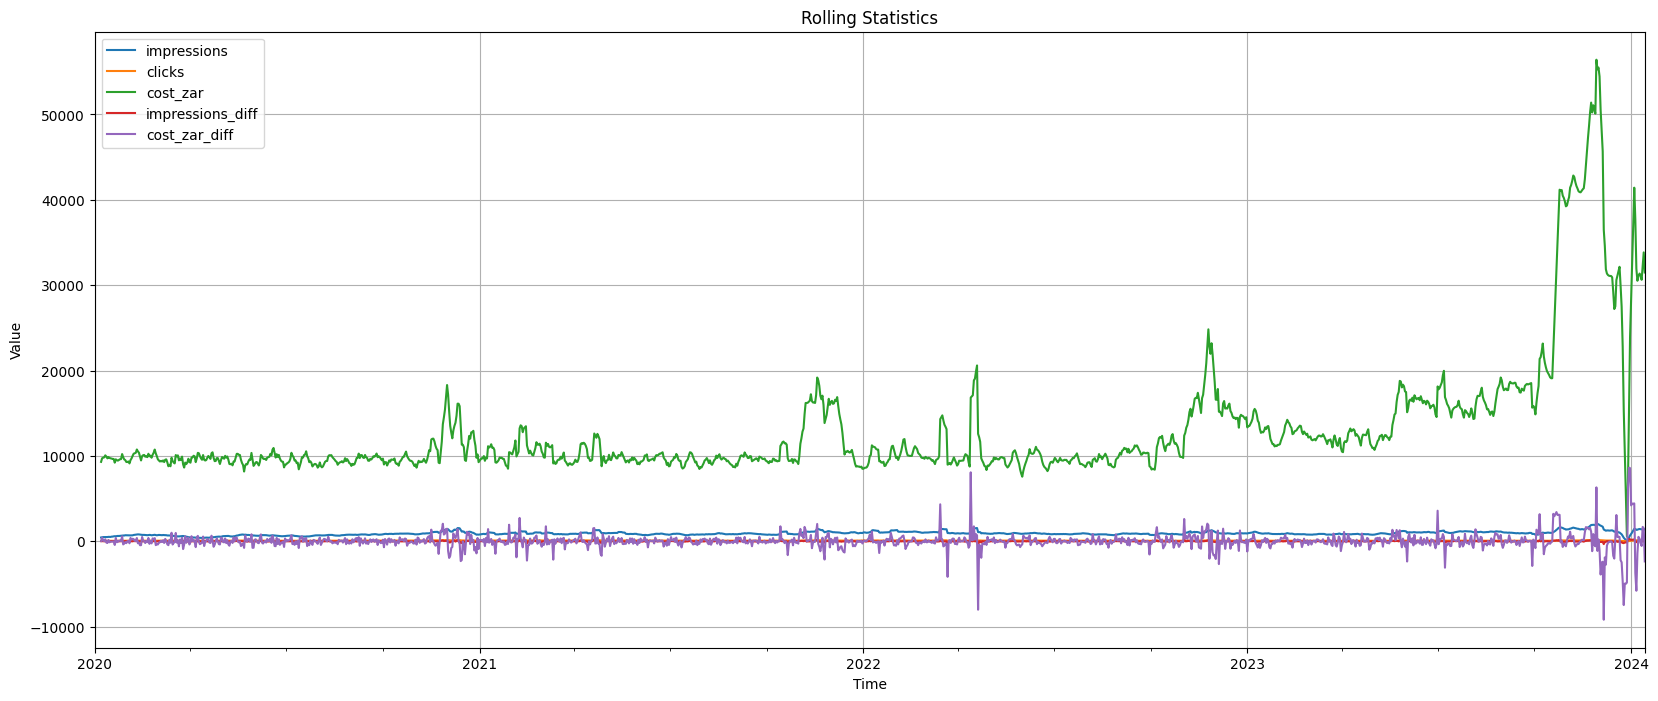

In [46]:
fig, ax = plt.subplots(figsize=(20, 8))
#plt.plot(numerics, label='Original Data')
rolling_mean.plot(ax = ax)
plt.title('Rolling Statistics')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True);

In [299]:
def difference(data, target):
    
    diff = data.drop(target, axis = 1).diff().fillna(0)
    dicto = {}
    
    for col in list(diff.columns):
        dicto[col] = f"{col}_diff"
    
    diff = diff.rename(columns=dicto)
    
    return pd.concat([data, diff], axis = 1)
numerics = difference(numerics, "clicks")

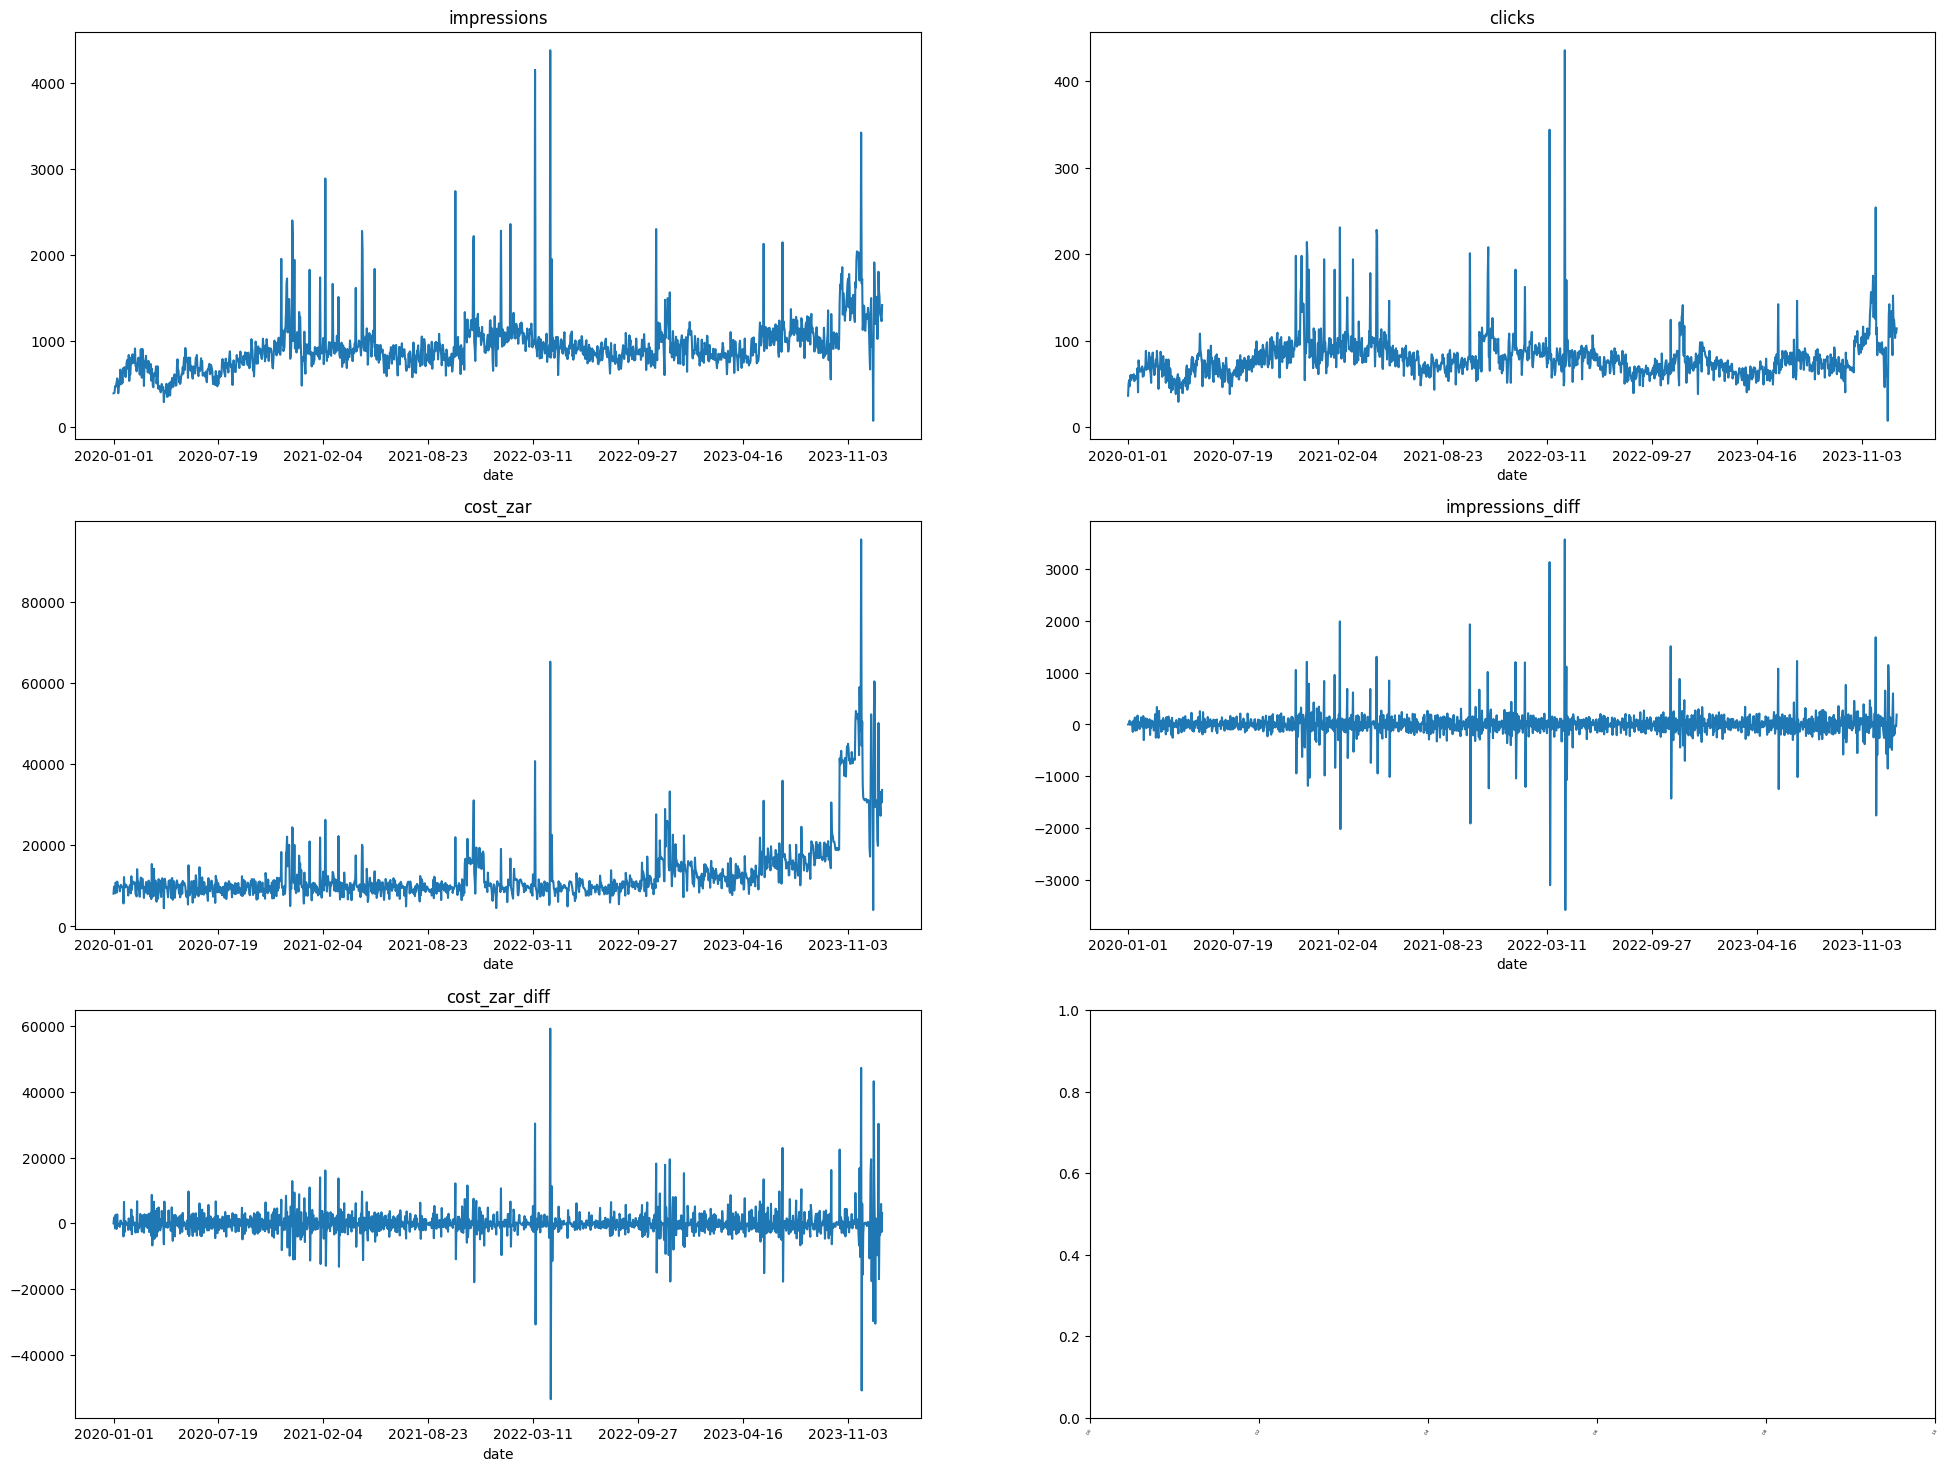

In [313]:
fig, ax = plt.subplots(figsize=(24,18),nrows=3, ncols=2)

for i,col in enumerate(data.columns):
    numerics[col].plot(ax=ax[i//2,i%2],title=col)
    plt.xticks(rotation = 60, fontsize = 3)

array([[<Axes: title={'center': 'impressions'}>,
        <Axes: title={'center': 'clicks'}>],
       [<Axes: title={'center': 'cost_zar'}>,
        <Axes: title={'center': 'impressions_diff'}>],
       [<Axes: title={'center': 'cost_zar_diff'}>, <Axes: >]],
      dtype=object)

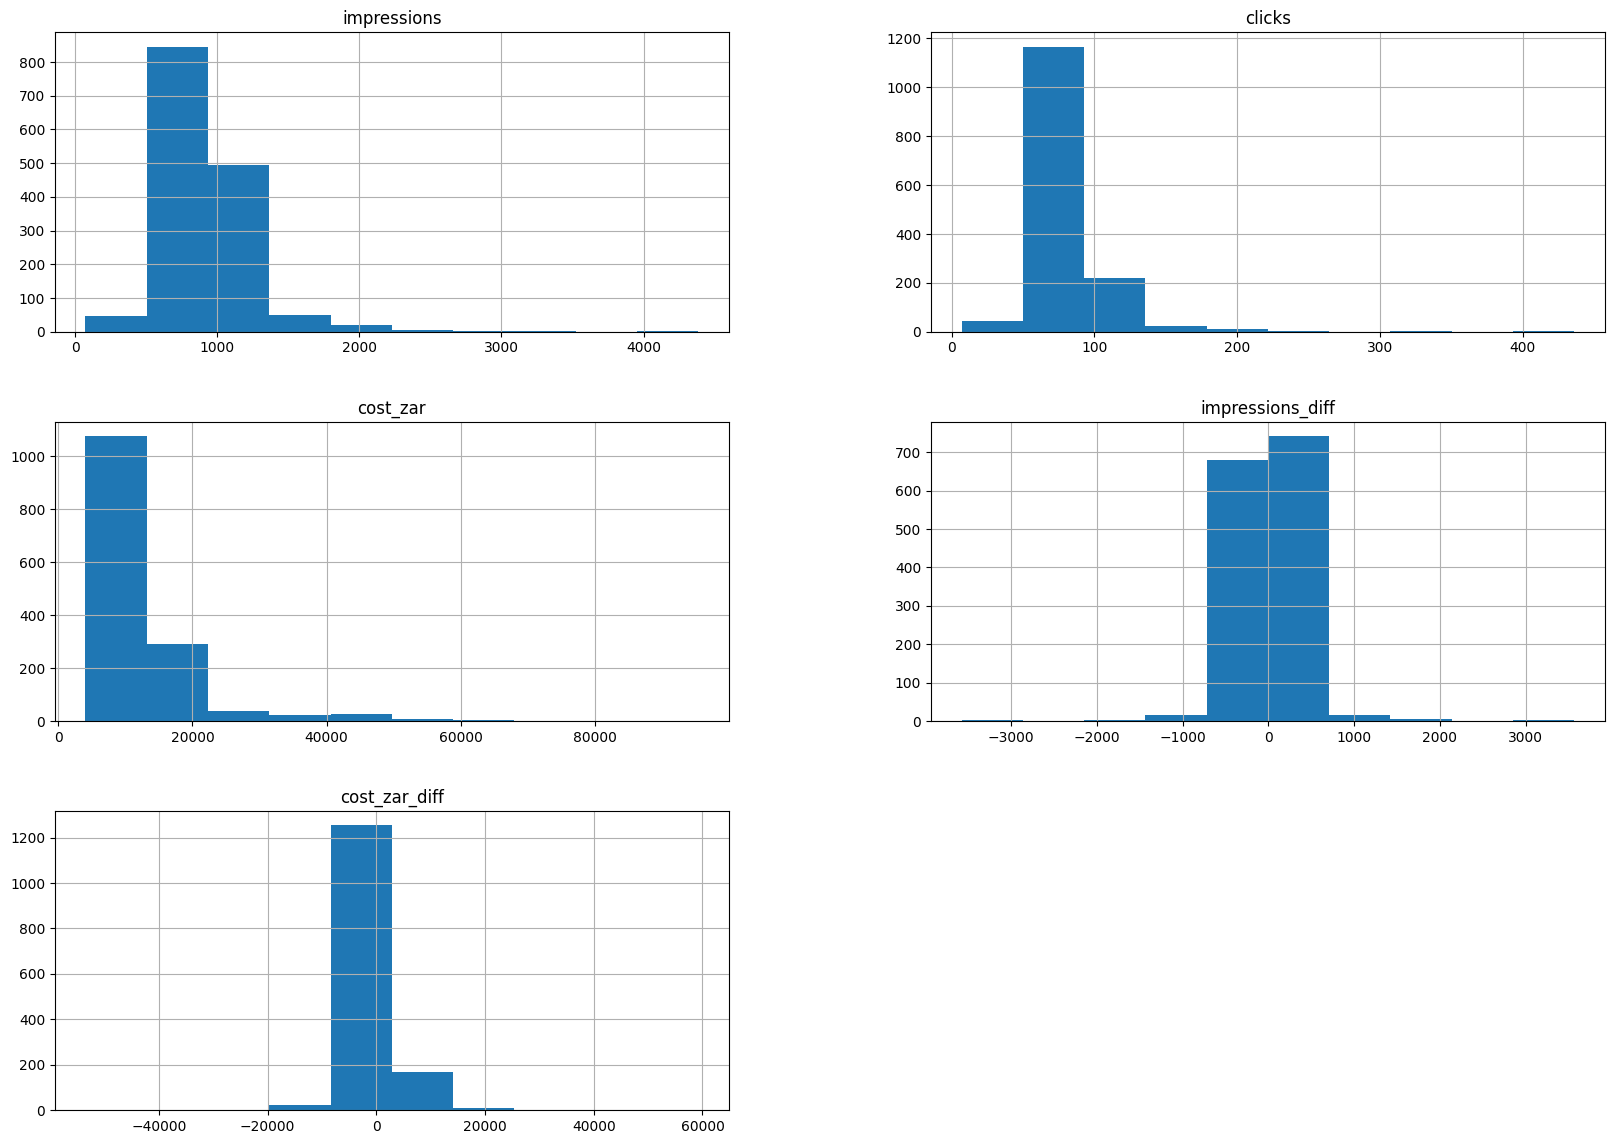

In [311]:
numerics.hist(figsize=(20,14))

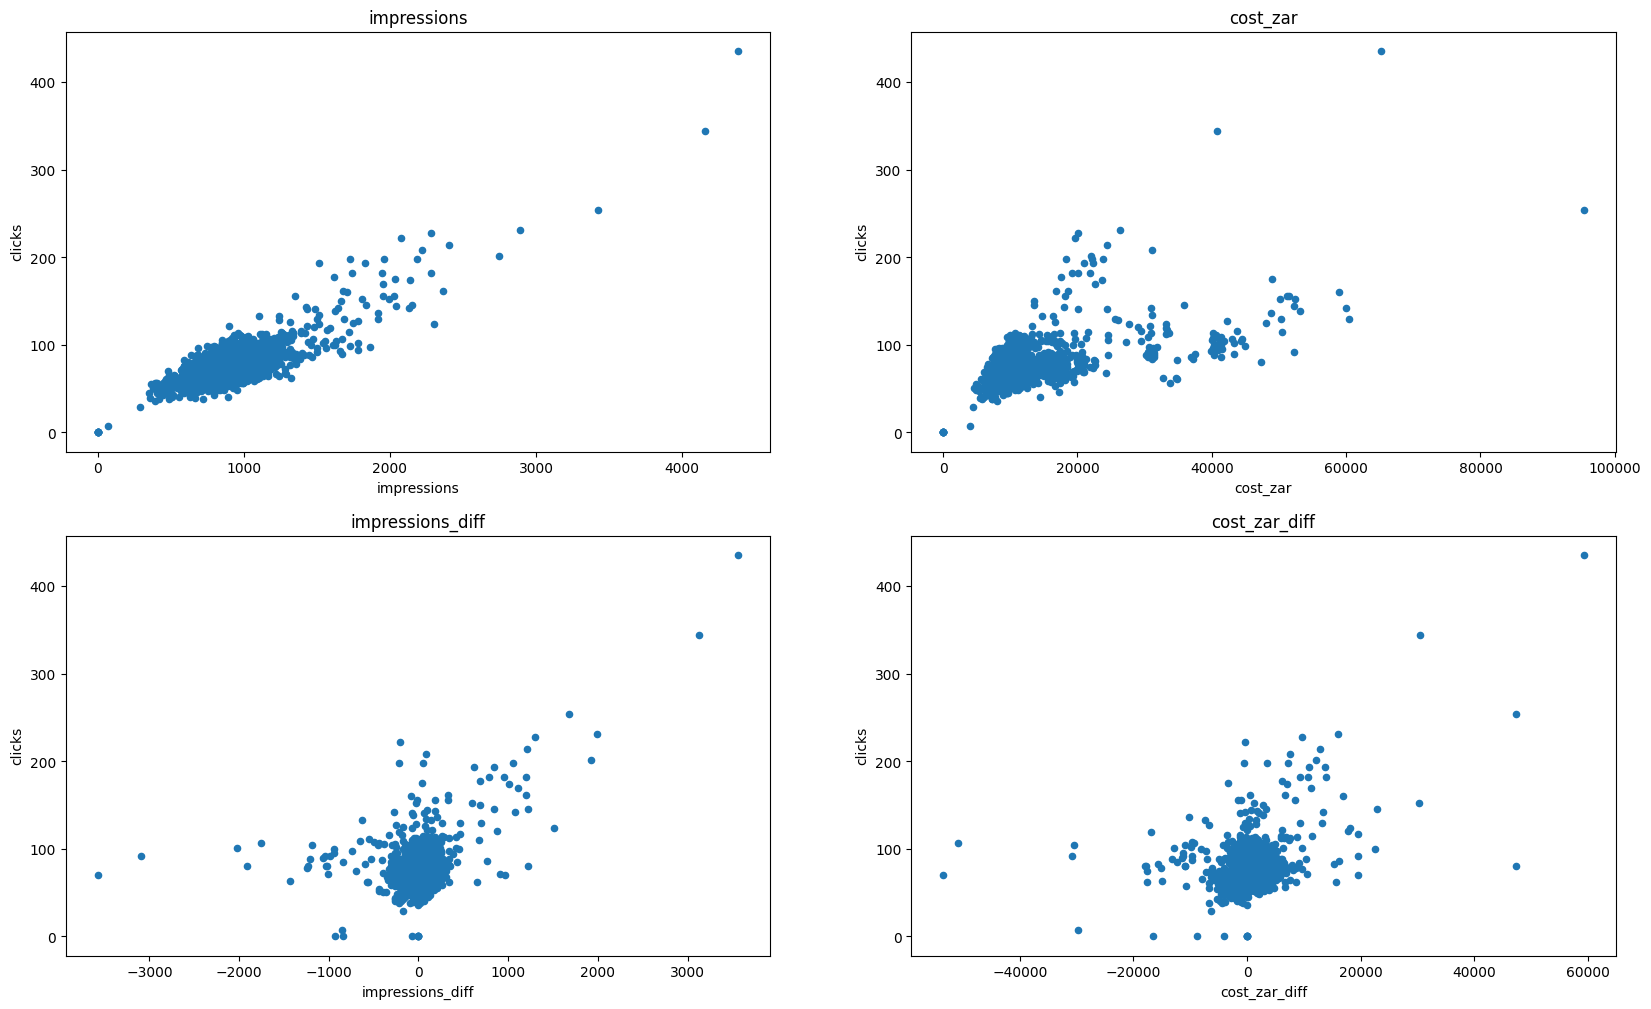

In [48]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2)

for i,col in enumerate(data.select_dtypes("number").drop(columns = "clicks").columns):
    data.select_dtypes("number").plot.scatter(x=col,y="clicks", ax= ax[i//2, i%2], title=col)

In [275]:
numerics.corr().style.background_gradient()

,impressions,clicks,cost_zar,impressions_diff,cost_zar_diff
impressions,1.000000,0.819488,0.704912,0.487204,0.375624
clicks,0.819488,1.000000,0.532962,0.442021,0.421564
cost_zar,0.704912,0.532962,1.000000,0.228010,0.311686
impressions_diff,0.487204,0.442021,0.228010,1.000000,0.751823
cost_zar_diff,0.375624,0.421564,0.311686,0.751823,1.000000


In [280]:
#numeric_data = data.select_dtypes("number").drop(columns=["clicks", "headline1_len", "impression_share", "headline2_len", "ad_description_len"])
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(numerics.drop(columns="clicks").values, i) for i in range(len(numerics.drop(columns="clicks").columns))]
vif_data["Feature Name"] = numerics.drop(columns="clicks").columns
vif_data

,VIF,Feature Name
0,7.577445,impressions
1,7.602179,cost_zar
2,2.483215,impressions_diff
3,2.499713,cost_zar_diff


In [315]:
data.head()

,impressions,clicks,cost_zar,EXPANDED_TEXT_AD,EXPANDED_DYNAMIC_SEARCH_AD,RESPONSIVE_SEARCH_AD
date,,,,,,
2020-01-01,393,36,8087,1,0,0
2020-01-02,395,50,9831,1,0,0
2020-01-03,404,54,9774,1,0,0
2020-01-04,476,47,8217,1,0,0
2020-01-05,466,59,10806,1,0,0


# Split

In [50]:
target = "clicks"
X = data.drop(columns = target).astype(int)
y = data[target].astype(int)
X.shape, y.shape

((1475, 7), (1475,))

In [51]:
cut_off = int(len(data)*0.8)
X_train, X_test = X.iloc[:cut_off], X.iloc[cut_off:]
y_train, y_test = y.iloc[:cut_off], y.iloc[cut_off:]

# Model

## Baseline

In [60]:
y_train_mean = y_train.mean()
baseline = [y_train_mean]*len(y_train)
mse = mean_squared_error(y_train, baseline)
print("score ---->", mse, "\n")
print("Baseline---->")
baseline[:5]

score ----> 651.5876551278368 

Baseline---->


[79.4635593220339,
 79.4635593220339,
 79.4635593220339,
 79.4635593220339,
 79.4635593220339]

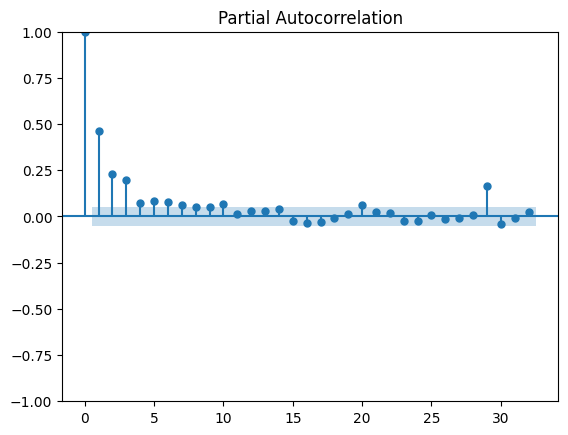

In [84]:
plot_pacf(data["clicks"]);

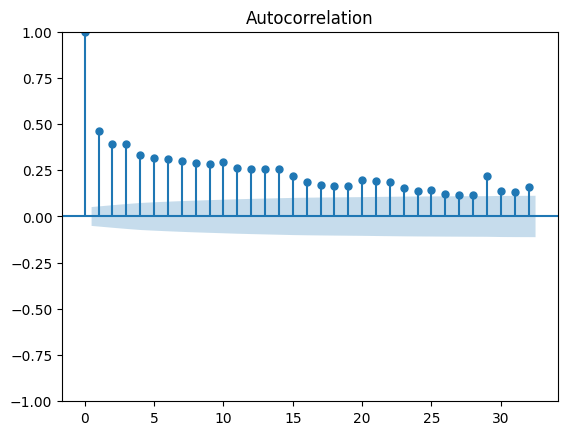

In [85]:
plot_acf(data["clicks"]);

In [95]:
p_params = range(1, 51, 10)
q_params = range(0, 10, 2)
p_params, q_params

(range(1, 51, 10), range(0, 10, 2))

In [102]:
mse_grid={}

for p in p_params:

    mse_grid[p] = list()

    for q in q_params:
        group_order = (p, 0, q)
        start_time = time.time()
        model = ARIMA(endog = y_train, order=group_order).fit()
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMAX {group_order} in {elapsed_time} seconds.")

        y_pred = model.predict()
        
        mse = mean_squared_error(y_train, y_pred)
        
        mse_grid[p].append(mse)

print("--->")
mse_grid


Trained ARIMAX (1, 0, 0) in 0.25 seconds.
Trained ARIMAX (1, 0, 2) in 1.16 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as startin

Trained ARIMAX (1, 0, 4) in 3.0 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (1, 0, 6) in 4.08 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (1, 0, 8) in 5.04 seconds.
Trained ARIMAX (11, 0, 0) in 1.98 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (11, 0, 2) in 7.17 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (11, 0, 4) in 8.61 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (11, 0, 6) in 9.17 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (11, 0, 8) in 9.92 seconds.
Trained ARIMAX (21, 0, 0) in 14.48 seconds.
Trained ARIMAX (21, 0, 2) in 15.81 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (21, 0, 4) in 28.89 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (21, 0, 6) in 32.43 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (21, 0, 8) in 35.03 seconds.
Trained ARIMAX (31, 0, 0) in 58.24 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (31, 0, 2) in 83.0 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (31, 0, 4) in 85.7 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (31, 0, 6) in 82.1 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (31, 0, 8) in 87.34 seconds.
Trained ARIMAX (41, 0, 0) in 74.18 seconds.
Trained ARIMAX (41, 0, 2) in 138.92 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (41, 0, 4) in 208.67 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (41, 0, 6) in 210.54 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (41, 0, 8) in 219.4 seconds.
--->


{1: [554.2198339400616,
  484.3191930277679,
  482.75946684642776,
  481.92812953041226,
  481.5820290665616],
 11: [484.0954710263599,
  480.1321315207533,
  479.77996134810627,
  477.176380796916,
  485.89404682355905],
 21: [475.58108902083023,
  475.6226069227022,
  468.79991295885105,
  470.6628300287944,
  468.22444076851616],
 31: [453.439032926311,
  453.1261494277022,
  452.70260404298966,
  450.71679486409204,
  450.47252071973054],
 41: [449.5980409464363,
  449.56851217493534,
  448.3773309751301,
  448.34160482945146,
  444.7179808181921]}

In [99]:
pd.DataFrame(mse_grid)

,1,11,21,31,41
0,69.649013,62.239578,60.431075,60.341008,60.114853
1,62.090413,62.350584,60.448635,59.905085,59.414380
2,61.875072,65.918688,60.797113,59.877745,60.131764
3,62.016091,102.802067,60.319136,60.300681,60.065964
4,62.080105,61.491068,64.983345,60.334614,60.094523


In [101]:
model = ARIMA(endog = y_train, exog = X_train, order=(41, 2, 1)).fit()
y_pred = model.predict()
mse = mean_squared_error(y_train, y_pred)
mse

c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


110.72887235352287

In [ ]:
model = ARIMA(endog=y_train, exog = X_train).fit()

## Corrected code to use as function for others data sets

In [38]:
def wrangle(raw_data_path):

    datas_hub = {}
    df = pd.read_csv(raw_data_path)



    def sub_wrangle(df, identifiant):
        
        # Substract the datafram according to the ID
        data = df[df["ID"].str.contains(identifiant)].copy()

        # Convert the cost in ZAR
        data.loc[data["currency"] == "USD", "cost_zar"] = data["cost"] * 19.18
        data.loc[data["currency"] != "USD", "cost_zar"] = data["cost"]

        drop_cols = ["ID", "currency", "cost", "conversions", "conversions_calls", "headline1_len", "impression_share", "headline2_len", "ad_description_len", "call_type", "call_status", "start_time", "duration", "end_time", "display_location"] # We don't need the ID anymore since it is only one  
        data = data.drop(columns=drop_cols)

        data = data.groupby("date").sum()
        data.index = pd.to_datetime(data.index)

        data = data.resample("D").sum().bfill()

        # Create new variables that will be True or False if the client lunched a campain of this ad_type
        data["EXPANDED_TEXT_AD"] = data["ad_type"].str.contains("EXPANDED_TEXT_AD")
        data["EXPANDED_DYNAMIC_SEARCH_AD"] = data["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
        data["RESPONSIVE_SEARCH_AD"] = data["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
        data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]] = data[["EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"]].fillna(False)
        
        data.drop(columns="ad_type", inplace=True)
        
        # Call the difference function to create new variables (allvariable_diff)
        def difference(data, target):
    
            diff = data.drop(target, axis = 1).diff().fillna(0)
            dicto = {}
            
            for col in list(diff.columns):
                dicto[col] = f"{col}_diff"
            
            diff = diff.rename(columns=dicto)
            
            return pd.concat([data, diff], axis = 1)
        
        data = difference(data, ["clicks", "EXPANDED_TEXT_AD", "EXPANDED_DYNAMIC_SEARCH_AD", "RESPONSIVE_SEARCH_AD"])

        return data
    
        # Call the subwrangle function

    return datas_hub